In [1]:
from ChromoGen import Conformations
from ChromoGen.data_utils import HiCDataset
from pathlib import Path
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('../support/plot_style.txt')

2024-11-22 20:39:11.582401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gm_mcool_fp = '../../outside_data/hic/GM12878_hg19.mcool'
imr_mcool_fp = '../../outside_data/hic/IMR90_hg19.mcool'

gm_conformations_dir = '../../downloaded_data/conformations/ChromoGen/genome_wide/GM12878'
imr_conformations_dir = '../../downloaded_data/conformations/ChromoGen/genome_wide/IMR90'

temp_data_dir = './temp_data/'
pdf_dir = './pdfs/'

use_gpu = True
high_precision = False

resolution = 20_000

In [3]:
gm_hic_dataset = HiCDataset(gm_mcool_fp, resolution = resolution)
imr_hic_dataset = HiCDataset(imr_mcool_fp, resolution = resolution)

gm_conformations_dir = Path(gm_conformations_dir)
assert gm_conformations_dir.exists()

imr_conformations_dir = Path(imr_conformations_dir)
assert imr_conformations_dir.exists()

temp_data_dir = Path(temp_data_dir)
temp_data_dir.mkdir(exist_ok=True,parents=True)

pdf_dir = Path(pdf_dir)
pdf_dir.mkdir(exist_ok=True,parents=True)

use_gpu = use_gpu and torch.cuda.is_available()

### Support

In [4]:
def get_insulation_score_correlations(
    chrom, 
    start_idx, 
    cgen_conformations_dir,
    hic_dataset,    
    window_size = 7, 
    resolution = resolution,
    r_c = 1.5, 
    sigma = 3.72, 
    decay_rate = 3.45,
    use_gpu = use_gpu,
    high_precision=high_precision
):
    ws = window_size

    if use_gpu:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    if high_precision:
        dtype = torch.double
    else:
        dtype = torch.float
    
    #####
    # Load/process

    # ChromoGen conformations
    f1 = cgen_conformations_dir / f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_1.0_rescaled_phi_0.0.pt'
    f2 = cgen_conformations_dir / f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_5.0_rescaled_phi_8.0.pt'
    cgen_coords = Conformations(f1,drop_invalid_conformations=True).cat(
        Conformations(f2,drop_invalid_conformations=True)).to_(dtype=dtype,device=device)
    cgen_IS = cgen_coords.compute_hic(r_c, sigma, decay_rate).compute_insulation(window_size=ws)
    del cgen_coords

    # Experimental Hi-C
    stop = start_idx + resolution * len(cgen_IS)
    exp_hic = hic_dataset.fetch(chrom, start_idx, stop, balance=True).to_(dtype=dtype,device=device)
    exp_IS = exp_hic.compute_insulation(window_size=ws)
    del exp_hic

    #####
    # Correlations
    # Be sure to remove the NaN values at the window's edges to prevent NaN correlations (where the window would go out of view)

    # ChromoGen vs experimental Hi-C
    cgen_corr = torch.corrcoef(
        torch.stack(
            [
                cgen_IS[ws:-ws],
                exp_IS[ws:-ws]
            ],
            dim=0
        )
    )[0,1].cpu()

    return cgen_corr
    

### Calculate/load insulation score correlations 

The GM correlations were calculated in `../Figure_3/PartF.ipynb`, hence my going to that directory as a check first.

Also, this is waaay faster than that other script because we don't rely on the (very slow) ConfigDataset class, so not parallelizing.

In [5]:
data_f = temp_data_dir / 'insulation_score_correlations.pt'
data_f1 = Path('../Figure_3/calc_results/insulation_score_correlations.pt')


if data_f.exists():
    results = torch.load(data_f)
else:
    results = {}
    if data_f1.exists():
        results['GM12878'] = torch.load(data_f1)['ChromoGen']
        calc_gm = False
    else:
        results['GM12878'] = {}
        calc_gm = True
    results['IMR-90'] = {}
    
    files = list(imr_conformations_dir.rglob('*1.0_rescaled_phi_0.0.pt'))
    files_hic = {'IMR-90':(files,imr_hic_dataset)}
    n = len(files)
    if calc_gm:
        files = list(gm_conformations_dir.rglob('*1.0_rescaled_phi_0.0.pt'))
        files_hic.update({'GM12878':(files,gm_hic_dataset)})
        n+= len(files)

    for ct,(files, hic_dataset) in files_hic.items():
        for f in tqdm(files,desc=ct):
            chrom = f.parent.name.split('_')[-1]
            start_idx = int(f.stem.split('_')[2]) * 1000

            if chrom not in results[ct]:
                results[ct][chrom] = {}
                
            results[ct][chrom][start_idx//1000] = get_insulation_score_correlations(
                chrom, 
                start_idx, 
                f.parent.parent, 
                hic_dataset
            )

    torch.save(results, data_f)


IMR-90:   0%|          | 0/2658 [00:00<?, ?it/s]

## Plot

In [6]:
chrom_sizes = hic_dataset.clr.chromsizes
def make_plot(data_dict,resolution=resolution,chrom_sizes=chrom_sizes):

    ########
    # Prep
    data = []
    chroms = [str(k) for k in list(range(1,23))+['X']]
    for chrom in chroms:

        chrom_vec = torch.empty(chrom_sizes[chrom] // resolution).fill_(torch.nan)

        for start_idx, corr in data_dict[chrom].items():
            # Adjust index to the 20 kb resolution. 
            # Also, adjust regions to fill in accounting for the overlap between regions
            # so that we don't overwrite data but rather give each region as much visibility
            # as possible. 
            i = int(start_idx // 20) + 4 
            j = i + 56
            chrom_vec[i:j] = corr

        data.append(chrom_vec)

    # so that we can show chromosome boundary tick marks
    chrom_boundaries = [0]
    for d in data:
        chrom_boundaries.append(len(d)+chrom_boundaries[-1])

    # Concatenate the data before plotting
    data = torch.cat(data)

    ########
    # Plot
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,1.5))

    im = ax.matshow(data.unsqueeze(0),vmin=-1,vmax=1,cmap='PRGn')

    cbar = fig.colorbar(im,fraction=.02,label='$\\rho$')
    ax.set_aspect(int(.02*len(data)))
    ax.set_yticks([])
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax.set_xlabel('Genomic index')
    ax.set_xticks([cb for cb in chrom_boundaries])
    ax.set_xticklabels([*['$\\mathdefault{'+f'{k}'+'}$' for k in range(1,23)],'X',''])

    return fig 

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 5 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fontTools.subset:Closing glyph list over 'glyf': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fo

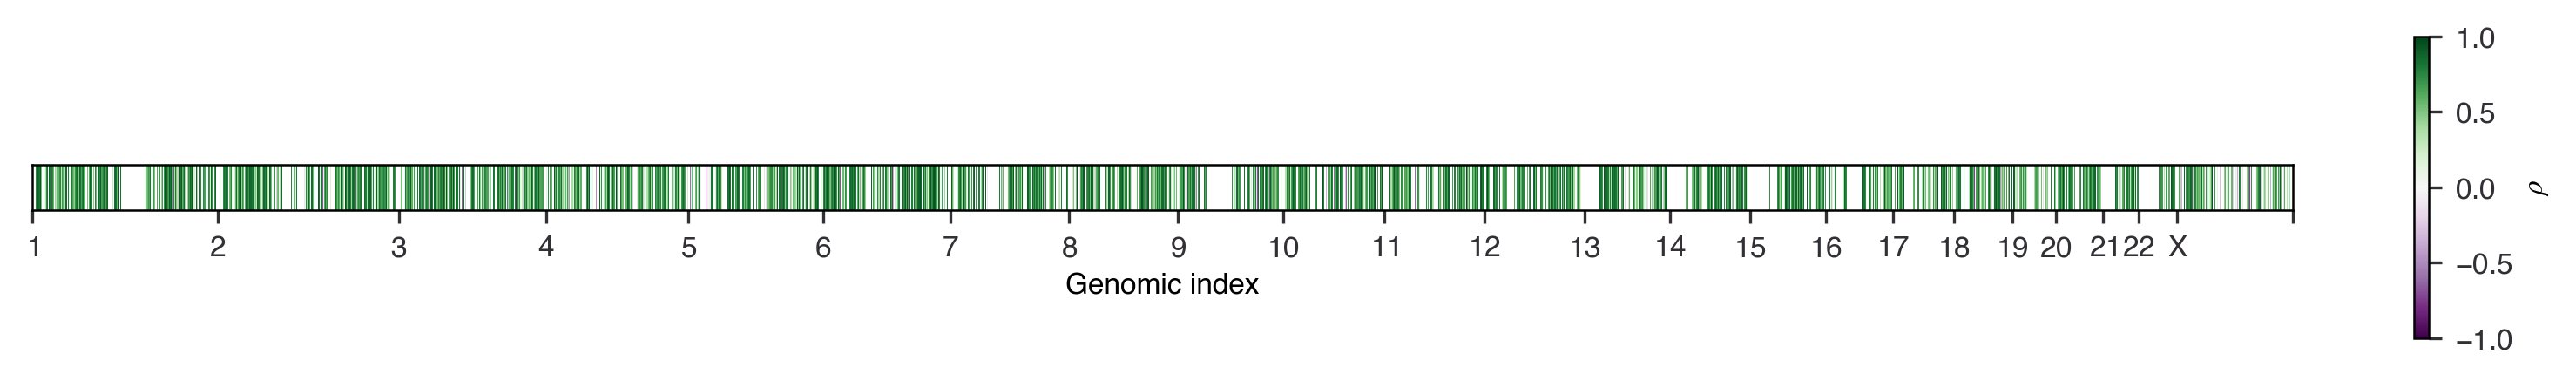

In [7]:
fig=make_plot(results['IMR-90'])
fig.savefig(pdf_dir / 'insulation_IMR90.pdf',transparent=True)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 5 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fontTools.subset:Closing glyph list over 'glyf': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fo

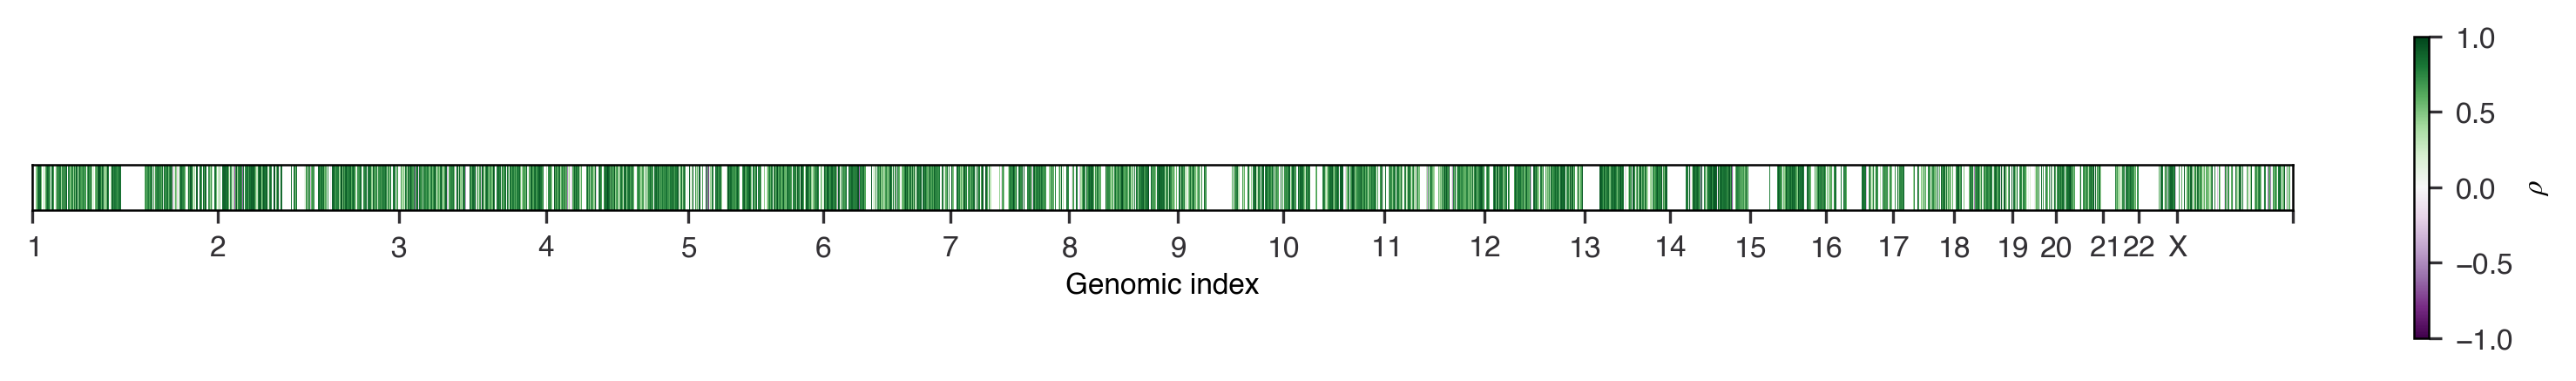

In [8]:
fig=make_plot(results['GM12878'])
fig.savefig(pdf_dir / 'insulation_GM12878.pdf',transparent=True)

Labels, etc., moved around in Adobe Illustrator